<a href="https://colab.research.google.com/github/gorogoro-uk/TensorFlow/blob/master/TF_4_4_TimeSeries_Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.2.0
BASE:    /content/sunspots
SUNSPOT_FILE:    sunspot_data.csv
SUNSPOT_URL:    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

Configuration complete


Data download complete


Read csv complete


Train, test dataset complete

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)

Windowed dataset complete

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)      

(1e-08, 0.0001, 0.0, 60.0)

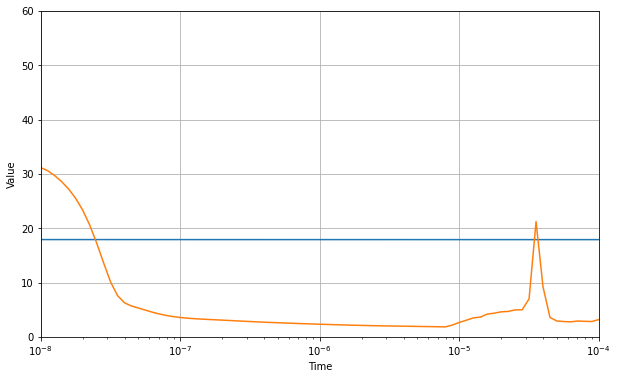

In [ ]:
# Sequence Data
# Sunspots

import tensorflow as tf
print(tf.__version__)
from pathlib import Path
import os
import urllib.request
import csv
import numpy as np
import matplotlib.pyplot as plt

# directories & data files
BASE = Path(os.getcwd()) / 'sunspots'
SUNSPOT_FILE = 'sunspot_data.csv'
SUNSPOT_URL = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
print(f"BASE:    {BASE}")
print(f"SUNSPOT_FILE:    {SUNSPOT_FILE}")
print(f"SUNSPOT_URL:    {SUNSPOT_URL}")
if not os.path.exists(BASE):
    os.mkdir(BASE)

print("\nConfiguration complete\n")

# get data & prep corpus
urllib.request.urlretrieve(SUNSPOT_URL,SUNSPOT_FILE)
print("\nData download complete\n")

# read csv file
time_step = []
temps = []
with open(SUNSPOT_FILE) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

# convert to numpy arrays
series = np.array(temps)
time = np.array(time_step)

# plot complete dataset
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time, series)
print("\nRead csv complete\n")

# split into train & test datasets
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_test = time[split_time:]
x_test = series[split_time:]
print("\nTrain, test dataset complete\n")

# train data pre-processing
# window, shuffle, batch

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)
print("\nWindowed dataset complete\n")


# define model
# LSTM with convolutions
sunspot_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
sunspot_model.summary()
print("\nModel definition complete\n")

# learning rate callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
sunspot_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# fit model
sunspot_model_hist = sunspot_model.fit(train_set, epochs=100, callbacks=[lr_schedule])

# plot loss by learning rate
plt.semilogx(sunspot_model_hist.history["lr"], sunspot_model_hist.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
# clear session for model run 2
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# prepare training dataset
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
print("\nTrain set preparation complete\n")

# define model
sunspot_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
sunspot_model.summary()

# use optimal learning rate
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
sunspot_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
print("\nModel definition complete\n")

# fit model
sunspot_model_hist = sunspot_model.fit(train_set,epochs=100)
print("\nModel fit complete\n")


Train set preparation complete

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)        

NameError: ignored

<Figure size 720x432 with 0 Axes>

[11.499058 10.763125 12.052721 ... 13.548933 13.746423 14.998709]


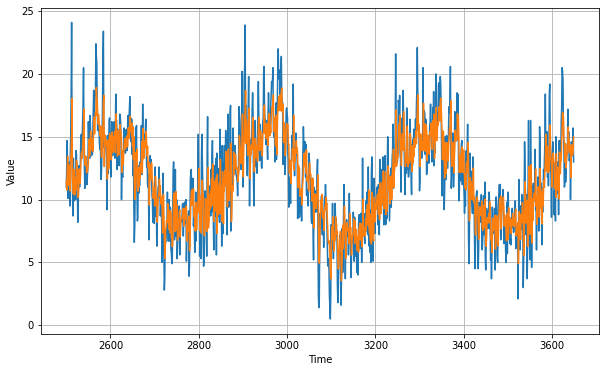

In [ ]:
# make forecast with model
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(sunspot_model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# plot results
plt.figure(figsize=(10, 6))
plot_series(time_test, x_test)
plot_series(time_test, rnn_forecast)

tf.keras.metrics.mean_absolute_error(x_test, rnn_forecast).numpy()  
print(rnn_forecast)
